In [1]:
import sys, os
import numpy as np
import time
import warnings
import pandas as pd
import seaborn as sns
from pprint import pprint
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

warnings.simplefilter('always', category=UserWarning)


def MSE(h, y):
    """
    Compute the Mean Squared Error for hypothesis h and targets y
    Args:
    """

def root_mean_squared_log_error(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

def collect_error_score(target, prediction):
    meansquare_error = mean_squared_error (prediction, target)                 # Mean Squared Error  
    r2square_error = r2_score(target, prediction)                              # R Squared  
    rmslog_error = root_mean_squared_log_error(prediction, target)             # Root Mean Square Log Error  
    #meanabsolute_error = mean_absolute_error (target, prediction)              # Absolute Mean Error 
    #msle = mean_squared_log_error(target, prediction)
    
    return ( meansquare_error, r2square_error, rmslog_error)

def error_table (score, labels, sort_col ):
    #labels  = ['Clf','mean absolute error','mean square error','R2 squared', 'Mean Sq Log Error', 'Root Mean Sq Log Error']
    scored_df = pd.DataFrame.from_records(score, columns=labels, index = None)
    sorted_scored = scored_df.sort_values(by = sort_col, ascending=True)
    return sorted_scored

# Data observation

The first useful thing to do with a dataset is to analyze it and observe the behaviours of each feature through graphs and charts. This helps to identify patterns and correlations between variables at a first glance. Of course, the first step is to clean up the dataset if necessary and prepare it for use.

In [2]:
### Prepare data

train = pd.read_csv(os.path.join("data", "train.csv"))  
test = pd.read_csv(os.path.join("data", "test.csv"))
train_size = train.shape
test_size = test.shape
validation_index = int(0.8 * train_size[0])

data_no_id = train.drop(["id"], axis=1)
X = train.drop(["id", 'formation_energy_ev_natom', 'bandgap_energy_ev'], axis=1)
Y1 = train['formation_energy_ev_natom']
Y2 = train['bandgap_energy_ev']

trainX = X[:validation_index]
validationX = X.iloc[validation_index:]
testX = test.drop(["id"], axis=1)
trainY1 = Y1[:validation_index]
trainY2 = Y2[:validation_index]
validationY1 = Y1[validation_index:]
validationY2 = Y2[validation_index:]

print(f"Number of training data ==> X: {trainX.shape[0]}, Y1: {trainY1.shape[0]}, Y2: {trainY2.shape[0]}")
print(f"Number of validation data ==> X: {validationX.shape[0]}, Y1: {validationY1.shape[0]}, Y2: {validationY2.shape[0]}")
print(f"Number of test data ==> X: {testX.shape[0]}")
print(f"Number of trainable features: {trainX.shape[1]}")

Number of training data ==> X: 1920, Y1: 1920, Y2: 1920
Number of validation data ==> X: 480, Y1: 480, Y2: 480
Number of test data ==> X: 600
Number of trainable features: 11


In [3]:
## Train dataset visualization

train_dataset_visualization_count = 7
print(f"Printing first {train_dataset_visualization_count} records of training dataset")
trainX.head(train_dataset_visualization_count)

Printing first 7 records of training dataset


,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893
5,227,40.0,0.5625,0.4375,0.000,9.8456,5.7176,14.1244,91.1235,91.3033,30.5730
6,206,80.0,0.0312,0.0938,0.875,10.1664,10.1664,10.1666,90.0009,90.0008,89.9987


In [4]:
## Training dataset statistics

print("Printing training dataset feature statistics")
trainX.describe()

Printing training dataset feature statistics


,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,140.556771,61.786458,0.381934,0.308809,0.309255,10.058304,7.124806,12.494803,90.257616,92.418684,94.472389
std,85.220402,22.500911,0.265045,0.233532,0.263090,5.617538,1.896444,5.379345,1.327645,5.289566,25.763891
min,12.000000,10.000000,0.000000,0.000000,0.000000,3.111300,2.942300,5.672500,83.189000,82.113400,29.727400
25%,33.000000,40.000000,0.156200,0.093800,0.083300,6.144850,5.842750,9.307100,89.999700,90.000900,89.998700
50%,194.000000,80.000000,0.375000,0.281200,0.281200,9.596700,6.403250,10.091500,90.001600,90.003500,90.000400
75%,206.000000,80.000000,0.562500,0.500000,0.468800,10.297625,9.119325,14.363400,90.005725,90.014150,119.997400
max,227.000000,80.000000,1.000000,1.000000,1.000000,24.913400,10.290300,25.346000,101.229800,106.168200,120.053500


In [5]:
## Geometry file

print("=== Showing geometry file ===")
xyz_dummy = pd.read_table(os.path.join("data", "train", "1", "geometry.xyz"))
xyz_dummy.head(8)

=== Showing geometry file ===


,#=======================================================
0,#Created using the Atomic Simulation Environme...
1,#=============================================...
2,lattice_vector 9.9520877199999997 -0.047248240...
3,lattice_vector 0.0403159900000000 8.5511748500...
4,lattice_vector 0.0316403800000000 0.0096659200...
5,atom 1.6088879366700000 7.2764162181499996 6.3...
6,atom 6.5849317966699994 7.2527920981499996 6.3...
7,atom 3.4357584130499994 1.2597758443300000 1.7...


The dataset provides a training dataset and a test dataset, but the latter has no target variables. Because the target variables are missing in the test dataset, I will use this to predict the values of the output variables, while I will split the training dataset into two subsets: a training dataset (80%) and a validation dataset (20%).

The training dataset consists of 2400 observations in total and 13 features. Out of these 13 features, 2 of these are categorical, while the rest are numerical. The features mostly show information about the unit cell of the given compound:
- 4 composition features: The **percent_atom** for "Al", "Ga" and "In" describe the relative composition of the material between the three elements. Each of these features range from 0 to 1. The **number_of_total_atoms** feature indicates the total number of atoms inside the unit cell and ranges from 10 to 80.
- Other training features describe the geometry of the unit cell, which is the fundamental building block of the material:
    - The **spacegroup** column explains the symmetry of the grid
    - The **lattice_vector** and **lattice_angle** features describe the spatial dimensions and distortions of the grid.
- **formation_energy_ev_atom** and **bandgap_energy_ev** are the target variables. They are floating point features measuring energies in the unit of the electron-volt (eV).

Each measurement represents a compound, which is also associated to a separate file (geometry.xyz) containing coordinates for all atoms inside the unit cell. The table in the **geometry.xyz** file encodes the positions of all atoms, therefore it is Nx3 in size, where N is the total number of atoms in the compound.

# Data Visualization

### Data



Formation energy mean: 0.188 +- 0.104 eV
Bandgap energy mean: 2.077 +- 1.007 eV 



C:\Users\loryc\AppData\Local\Temp\ipykernel_8556\440972744.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['formation_energy_ev_natom'], bins=150, color='#db2e79', ax=ax[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\loryc\AppData\Local\Temp\ipykernel_8556\440972744.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histogra

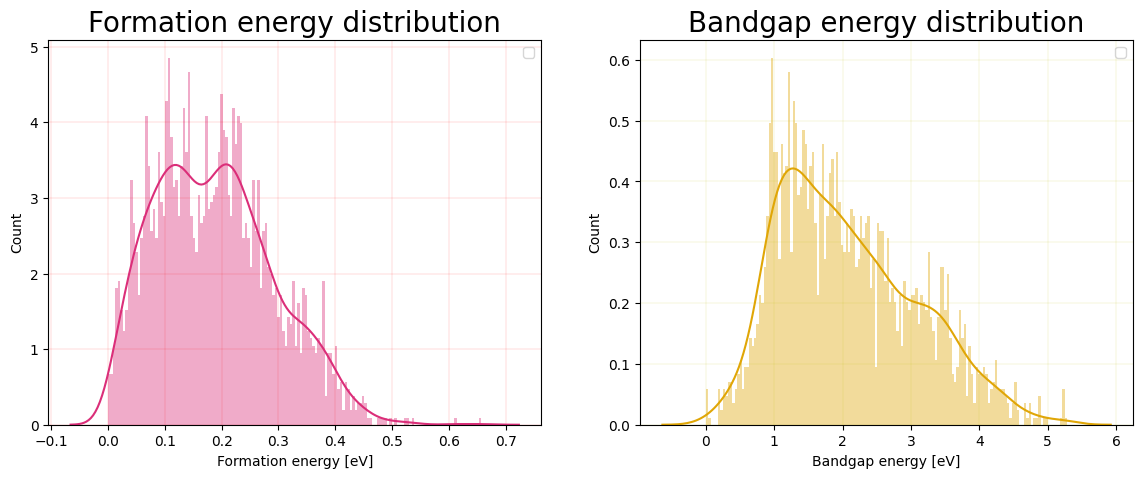

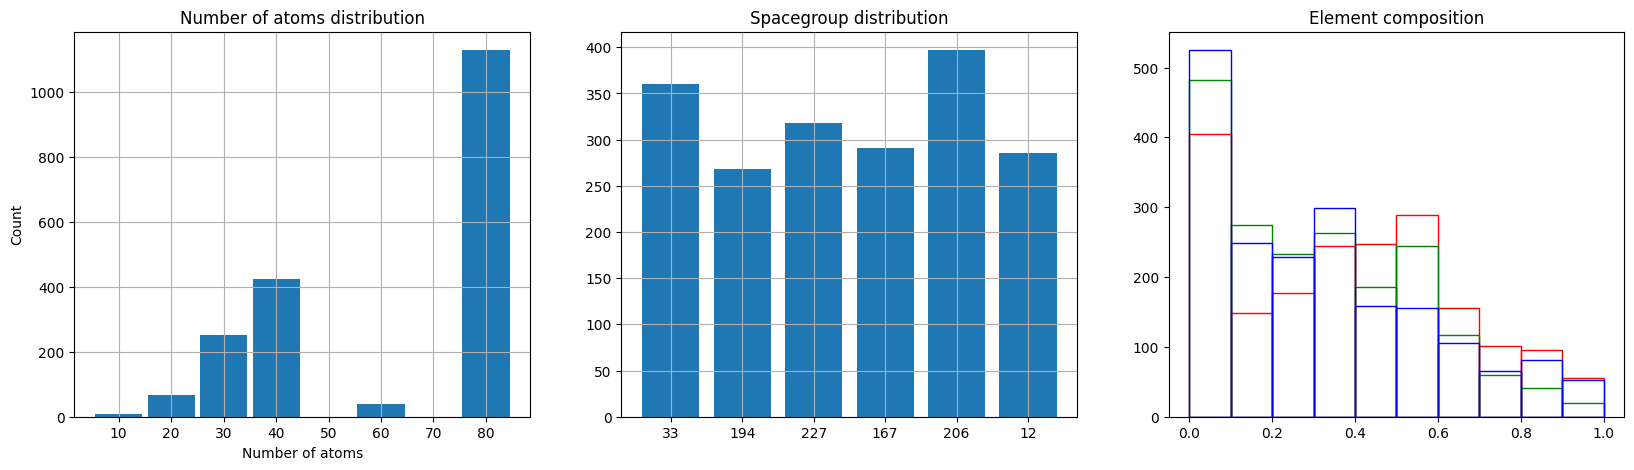

In [6]:
from collections import Counter


mean_formation_energy = np.mean(Y1)
mean_bandgap_energy = np.mean(Y2)
std_formation_energy = np.std(Y1)
std_bandgap_energy = np.std(Y2)
print(f"Formation energy mean: {mean_formation_energy:.3f} +- {std_formation_energy:.3f} eV")
print(f"Bandgap energy mean: {mean_bandgap_energy:.3f} +- {std_bandgap_energy:.3f} eV", "\n")

### Energy distributions
fig, ax = plt.subplots(1, 2, figsize=(14,5))
Y1_plot = Y1[Y1 >= 0.001]
sns.distplot(train['formation_energy_ev_natom'], bins=150, color='#db2e79', ax=ax[0])
ax[0].grid(color='r', linestyle='-', linewidth=0.1)
#ax[0].axvline(x=mean_formation_energy, color="red", label=f"Mean formation energy: {mean_formation_energy:.2f} eV")
ax[0].set_title("Formation energy distribution", fontsize=20)
ax[0].set_xlabel("Formation energy [eV]")
ax[0].set_ylabel("Count")
#ax[0].set_xscale("log")
ax[0].legend()

sns.distplot(train['bandgap_energy_ev'], bins=150, color='#e0a606',ax=ax[1])
ax[1].grid(color='y', linestyle='-', linewidth=0.1)
#ax[1].axvline(x=mean_bandgap_energy, color="red", label=f"Mean bandgap energy: {mean_bandgap_energy:.2f} eV")
ax[1].set_title("Bandgap energy distribution", fontsize=20)
ax[1].set_xlabel("Bandgap energy [eV]")
ax[1].set_ylabel("Count")
ax[1].legend()
plt.show()

### Feature representation
# Number of atoms
fig, ax = plt.subplots(1, 3, figsize=(20,5))
n_total_atoms_dict = dict(Counter(trainX['number_of_total_atoms']))
ax[0].bar(n_total_atoms_dict.keys(), n_total_atoms_dict.values(), width=9)
ax[0].set_title("Number of atoms distribution")
ax[0].set_xlabel("Number of atoms")
ax[0].set_ylabel("Count")
ax[0].grid(True)

# Spacegroups
spacegroup_dict = dict(Counter(trainX['spacegroup']))
ax[1].bar([i for i in range(0, len(spacegroup_dict))], spacegroup_dict.values())
ax[1].set_xticks([i for i in range(0, len(spacegroup_dict))], [str(i) for i in list(spacegroup_dict)])
ax[1].set_title("Spacegroup distribution")
ax[1].grid(True)
#ax[1].set_xticklabels([str(i) for i in list(spacegroup_dict.keys())])

# Composition
ax[2].hist(trainX['percent_atom_al'], fill=False, edgecolor="r")
ax[2].hist(trainX['percent_atom_ga'], fill=False, edgecolor="g")
ax[2].hist(trainX['percent_atom_in'], fill=False, edgecolor="b")
ax[2].set_title("Element composition")


plt.show()

These graph show interesting properties of the compounds forming the dataset:
- The formation energies are largely contained in the range 0.01-0.5 eV. Note that the x scale is logarithmic.
- The bandgap energies are approximately centered on 1 eV.
- The total number of atoms of the compound take discrete values, so a barplot has been chosen to represent the data. The primary value is 80 atoms.
- The same logic is applied to the spacegroup distribution, where the values are more evenly spread.

The next features to look at are the angles and lengths of the lattice vectors. Since we are talking about angles, a polar plot has been chosen to represent the data.

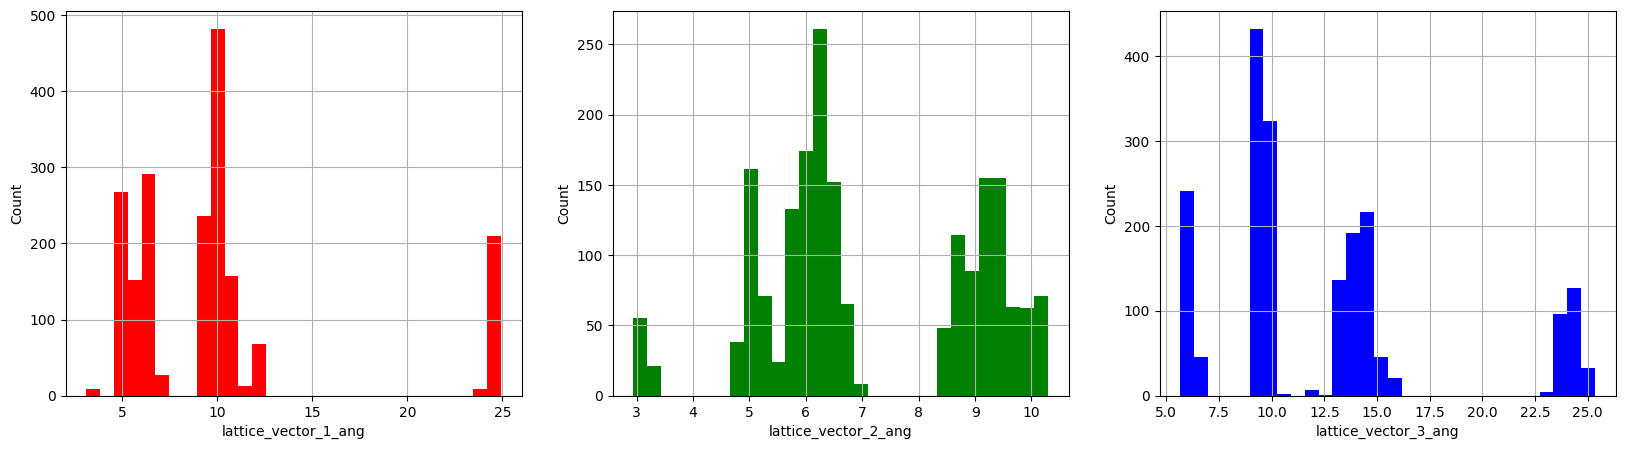

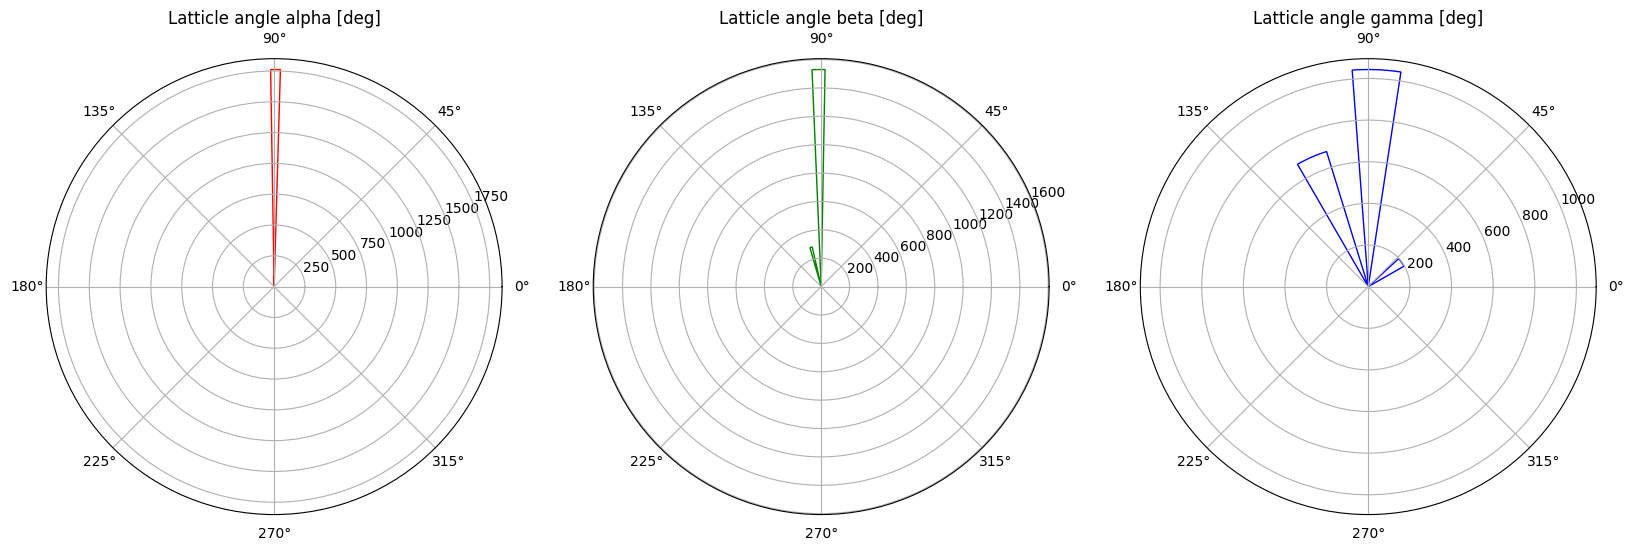

In [7]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
colours = ['r', 'g', 'b']
angles = ['alpha', 'beta', 'gamma']

for i in range(3):
    ax[i].hist(trainX[f'lattice_vector_{i+1}_ang'], color=colours[i], bins=30)
    ax[i].set_xlabel(f'lattice_vector_{i+1}_ang')
    ax[i].set_ylabel("Count")
    ax[i].grid(True)

fig, ax = plt.subplots(1, 3, figsize=(20,6), subplot_kw=dict(projection='polar'))

for i in range(3):
    ax[i].hist( np.radians(trainX[f'lattice_angle_{angles[i]}_degree']), color=colours[i], bins=7, fill=False, edgecolor=colours[i])
    #ax[i].set_yscale("log")
    ax[i].set_title(f"Latticle angle {angles[i]} [deg]")

We note from these graphs that:
- The lengths of the lattice vectors, describing the positions of the atoms within the grid cell, are grouped into 3 to 4 different peaks.
- The associated angles also group up at different values. Most angles take values around 90°, except for the gamma angle which covers a larger variety of angles.

### Feature Interaction
The numerical nature of this dataset invites for a first look at the correlation matrix between variables. This is done using pandas' ```corr``` function. The visualization is done thanks to seaborn's ```heatmap``` function. The higher the absolute value of the pair of features, the higher their correlation is (darker colour). If the value is negative, there is an anticorrelation. The closer the value is to zero (lighter colour), the weaker the correlation.
The target variables are at the bottom of the y-axis and at the right of the x-axis.

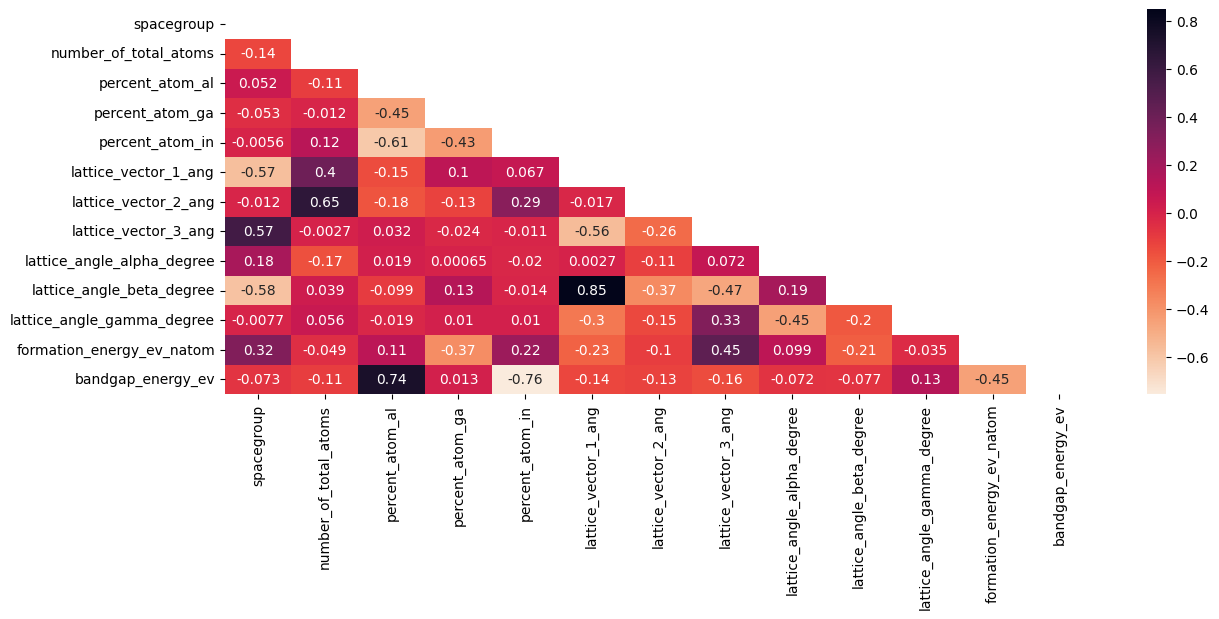

In [8]:
fig, ax = plt.subplots(figsize=(14,5))
corr=data_no_id.corr()
matrix = np.triu(corr)
dataplot = sns.heatmap(corr, cmap="rocket_r", annot=True,mask=matrix) 

From this heatmap we can see that:
- The bandgap energy strongly correlates with the amount of Aluminium in the compount, and strongly anti-correlates with the percent of Indium atoms in the compound, with a value of -0.76. 
- The formation energy has no remarkable correlations, and mostly correlates with the the lattice vector length of the 3rd axis, although it is not as strong as the above-mentioned correlations.
- Outside of the target variables, there's a strong correlation between the total number of atoms and the vector length of the 2nd grid axis, as well as the beta lattice angle and the vector length of the 1st grid axis.

More information of these correlations can be extrapolated from a pairplot

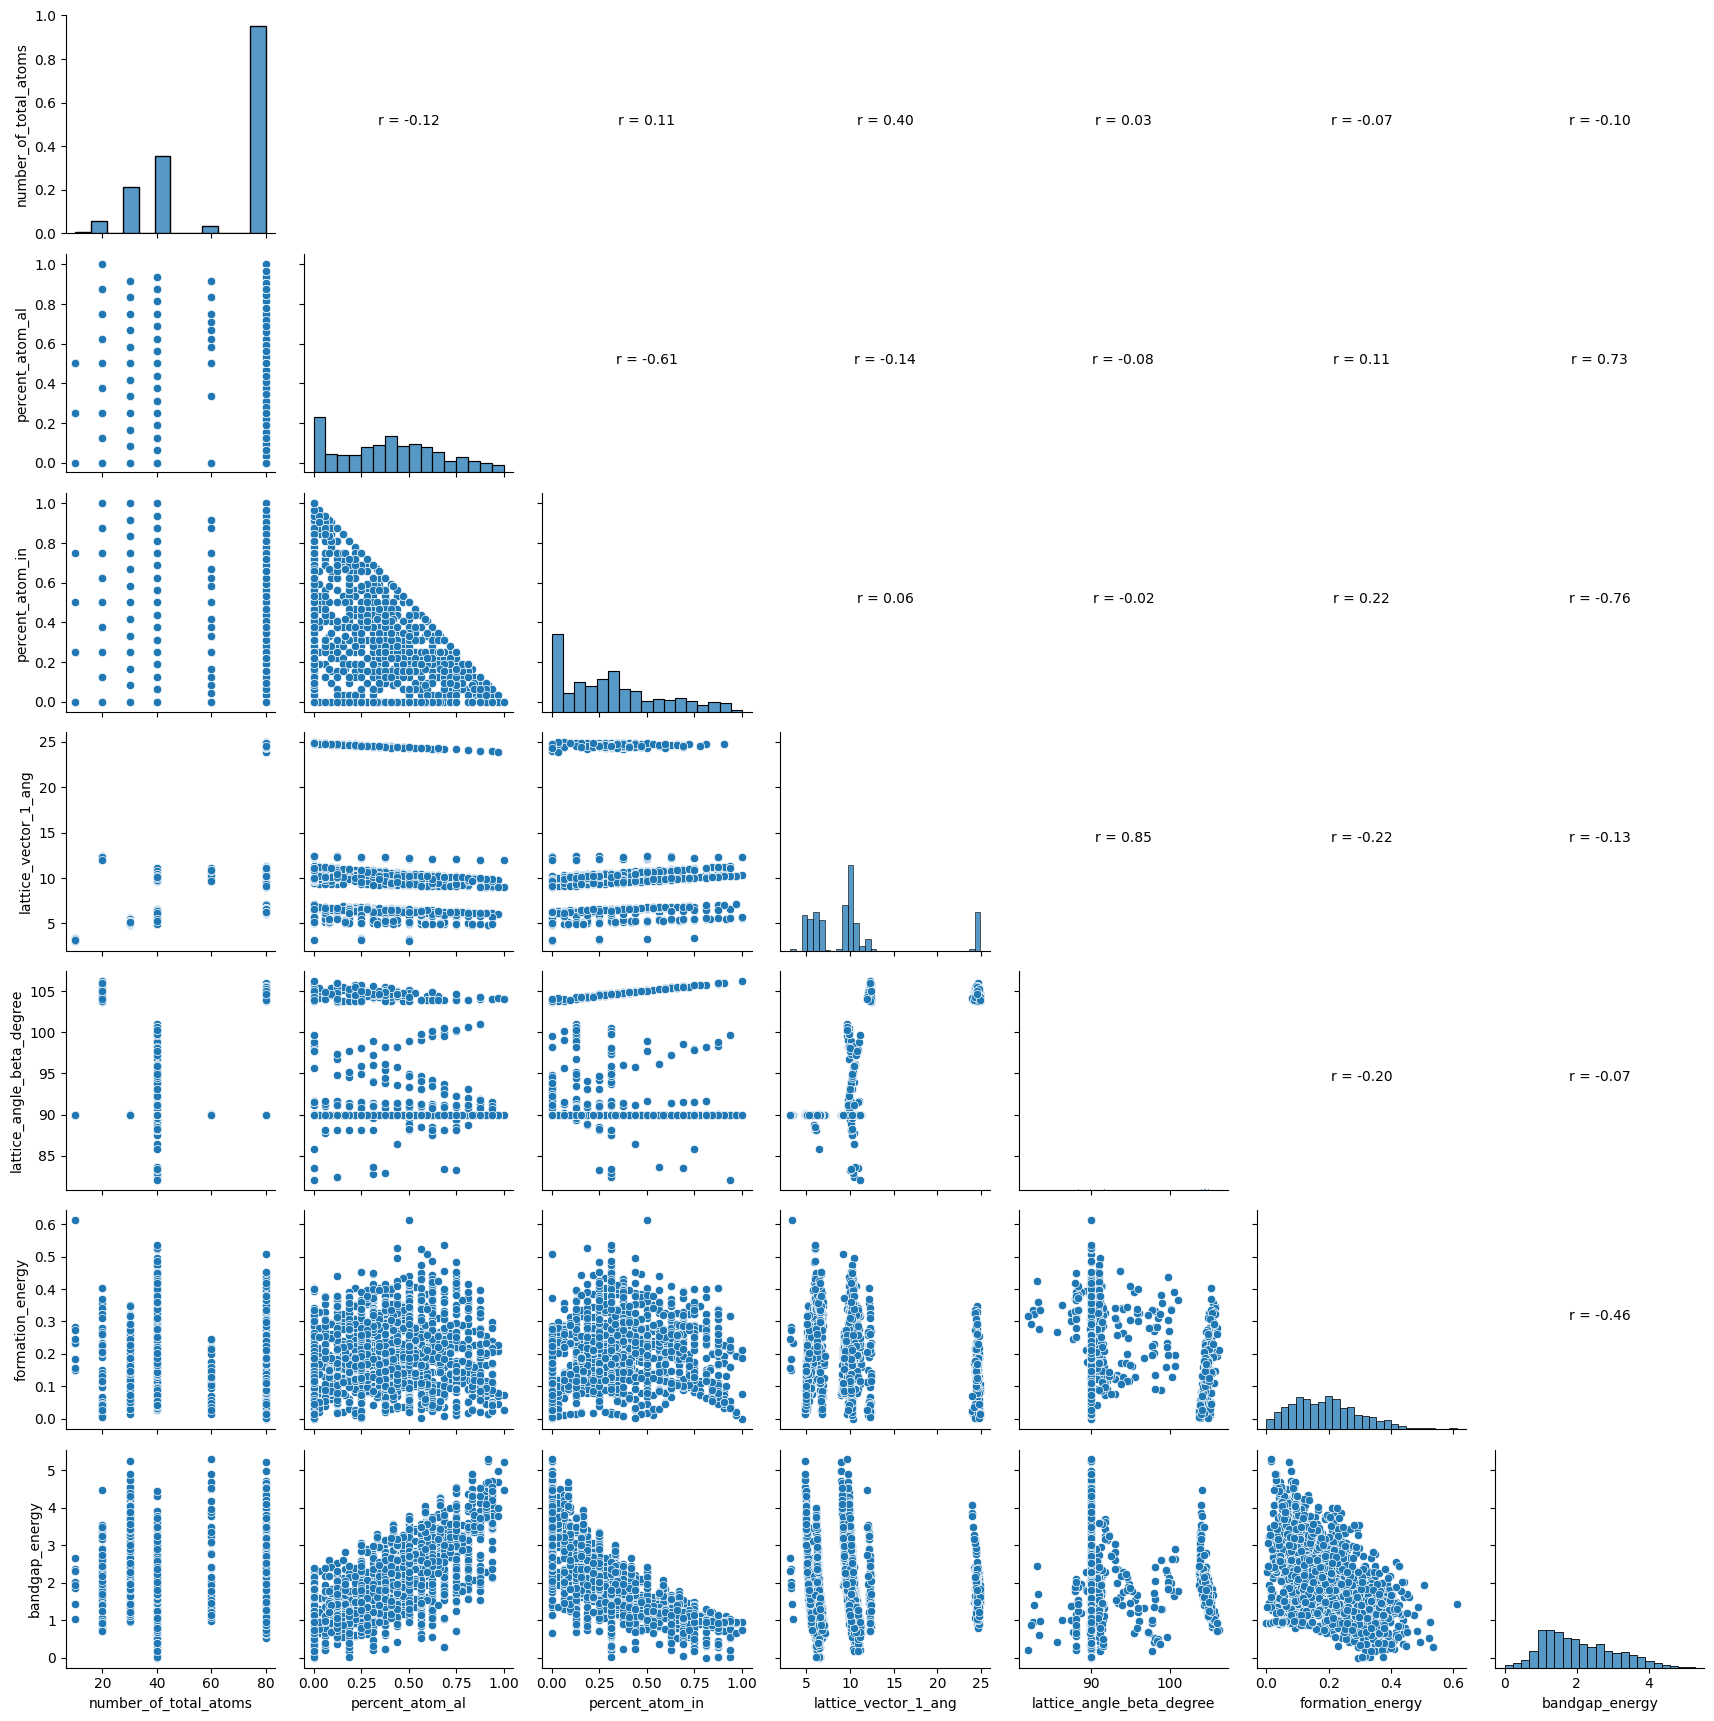

In [9]:
from scipy.stats import pearsonr

pairplot_data = trainX.drop(
    [
        "spacegroup",
        "percent_atom_ga",
        "lattice_vector_2_ang",
        "lattice_vector_3_ang",
        "lattice_angle_alpha_degree",
        "lattice_angle_gamma_degree"
    ], axis=1
)
pairplot_data["formation_energy"] = Y1
pairplot_data["bandgap_energy"] = Y2

from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

grid = sns.PairGrid(data=pairplot_data)
grid.map_lower(sns.scatterplot)
grid.map_diag(sns.histplot)
grid.map_upper(reg_coef)
plt.show()

We can state that:
- There is an increasing trend of bandgap energy with the amount of Aluminium present in the compound, and a decreasing trend between bandgap energy and percentage of Indium.
- There might be a correlation between the two target variables: formation and bandgap energies
- Beta angles outside the 90 value appear mostly when the total number of atoms is 40 and the vector length of the 1st grid axis is 10.


### Formation energies

Explore formation energy feature

#### Bandgap energies
In this section we briefly explore the bandgap_energy_ev feature.

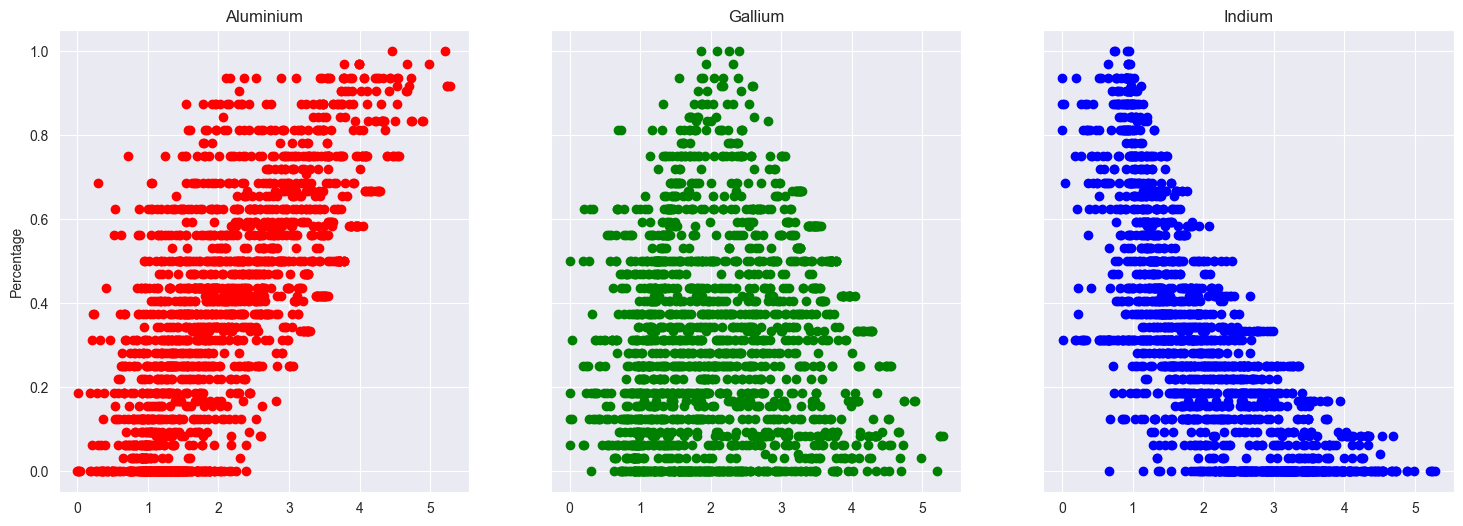

In [10]:
sns.set_style("darkgrid")
sns.color_palette()

fig, ax = plt.subplots(1, 3, figsize=(18,6), sharey=True)

ax[0].set_ylabel("Percentage")
ax[0].scatter(trainY2, trainX["percent_atom_al"], color="red")
#g = sns.regplot(data=train, x="bandgap_energy_ev", y="percent_atom_al", ax=ax[0])
ax[0].set_title("Aluminium")



ax[1].scatter(trainY2, trainX["percent_atom_ga"], color="green")
#g = sns.regplot(data=train, x="bandgap_energy_ev", y="percent_atom_ga", ax=ax[1])
ax[1].set_title("Gallium")


ax[2].scatter(trainY2, trainX["percent_atom_in"], color="blue")
#g = sns.regplot(data=train, x="bandgap_energy_ev", y="percent_atom_in", ax=ax[2])
ax[2].set_title("Indium")

plt.show()

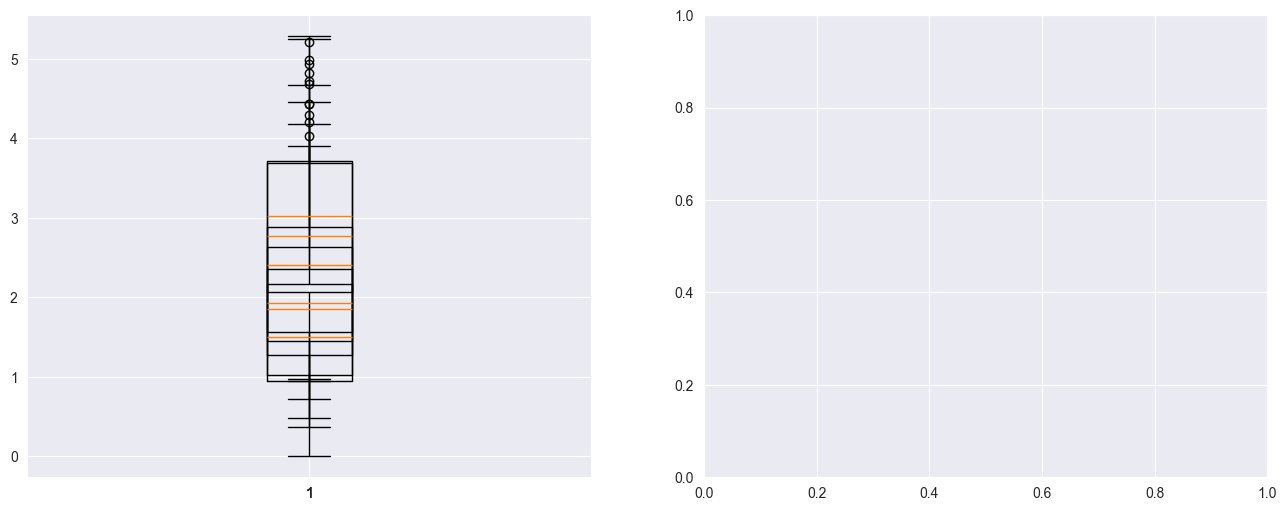

In [18]:
spacegroups = list(set(train['spacegroup']))
natoms = list(set(train['number_of_total_atoms']))

fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i in range(0,len(natoms)):
    natom_df = train[train['number_of_total_atoms'] == natoms[i]]
    ax[0].boxplot()

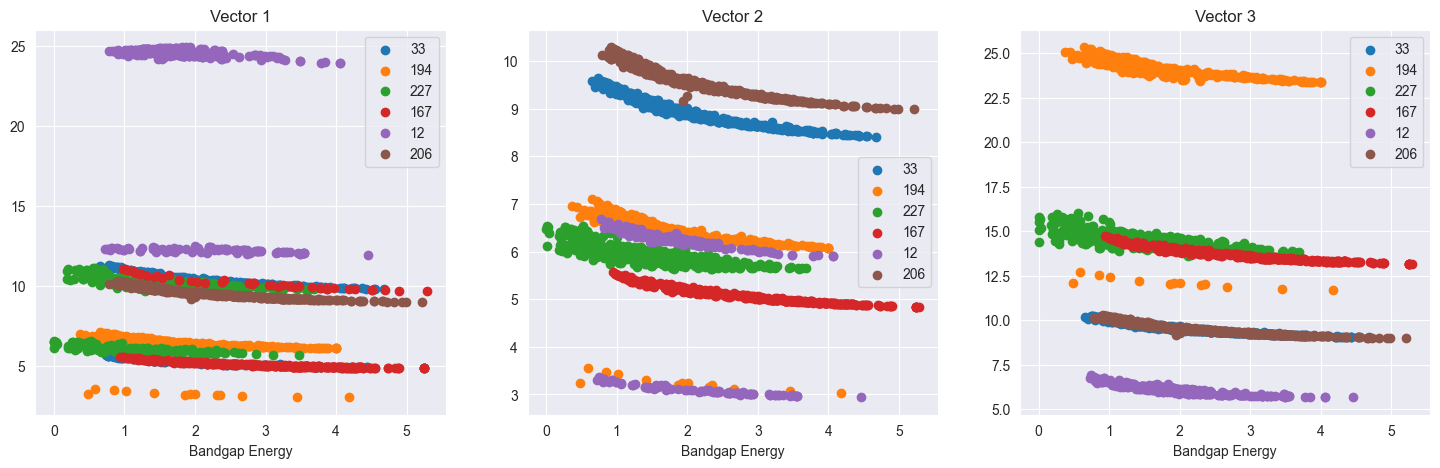

In [17]:


fig, ax = plt.subplots(1, 3, figsize=(18,5))
for i in range(0,3):
    for sg in spacegroups:
        sg_df = train[train['spacegroup'] == sg]
        x = sg_df['bandgap_energy_ev']
        y = sg_df[f'lattice_vector_{i+1}_ang']
        ax[i].scatter(x, y, label=f"{sg}")
        ax[i].set_title(f"Vector {i+1}")
        ax[i].set_xlabel("Bandgap Energy")
        ax[i].legend()

# Model selection

The objective is to develop a model, including methods of regularization, to best fit the training data and predict new data. The main evaluation method for a model is the Mean Squared Error (MSE), given by the formula:

$ MSE(\hat{y}) = \frac{1}{N} \sum_{i=1}^{N} (y - \hat{y})^2 $,

but other evaluation methods are reported as well, such as the Root Mean Squared Logarithmic Error.





Looking at